# Feature Vector Calculations
The purpose of this notebook is to write out formulas for calculating feature vector updates and to document the thought process for the implementation of feature vectors and the dictionary outside of the final program.

## Statistical Calculations

### Average
Below is the formula for calculating the current average, $\mu_{n}$, for different fields with only the calculated average from one previous time step, $\mu_{n-1}$, and the current value update for the field, $x_{n}$. This can be used on any of the fields present in the track dataset.

$$
\mu_{n} = \frac{(n-1)\mu_{n-1} + x_{n}}{n}
$$

### Standard Deviation
Below is the formula for calculating the current standard deviation, $\sigma_{n}$, with only the previously calculated standard deviation from the last time step, $\sigma_{n-1}$, and the current value update for the field, $x_{n}$. This can be used on any of the fields present in the track dataset.

$$
\sigma_{n} = \sqrt{\frac{(n-1)\sigma_{n-1}^{2} + (x_{n}-\mu_{n})^2}{n}}
$$

## Smoothness Calculations

Below are the formulas for calculating both the smoothness $M(1)$ and $M(2)$ metrics. These metrics convey the relative visual smoothness of a signal processed from any of the fields either provided by the kinematic track data or features calculated throughout the script. Added variables $q$ and $c$ are also specified in the equations. $z_n$ is any field or calculated feature at the current time interval.
$$
q_{n} = \frac{1}{n}(q_{n-1} * (n-1) + (z_{n} - z_{n-1}))
$$
$$
M(1)_n = \frac{1}{n}(M(1)_{n-1}*(n-1)+(z_{n}-z_{n-1}-q)^2)
$$
$$
c_n = \frac{1}{n}(c_{n-1}*(n-1)+|z_{n}-z_{n-1}|)
$$
$$
M(2)_n=\frac{M(1)_n}{c_n}
$$

## Euclidean Distance - 3D

Below is the three dimensional euclidean distance formula. For constructing the three dimensional coordinate space, we will use $latitude$ and $longitude$ of each track update as the $x$ and $y$ axis and $altitude$ as the $z$ axis. 

$$ d_{n}=||p-q|| = \sqrt{(lat_{a}-lat_{b})^2+(lon_{a}-lon_{b})^2+(alt_{a}-alt_{b})^2}$$

## Curvature

Using the three dimensional euclidean distance formula show above, curvature is calculated using the formula shown below where $a$, $b$, and $c$ are the calculated euclidean distances between 3 consecutive track updates (update 1 to 2, update 2 to 3, and update 1 to 3). This curvature formula will be considered a short term measurement of curvature, work is being done to investigate what a longer interval curvature measurement would look like.

$$ 
\kappa_{n} = cos^{-1}\frac{a^2-b^2-c^2}{2bc}
$$

## Heading

$$
h_{n} = tan^{-1}(lon_{n-1} - lon_{n}, lat_{n-1} - lat_{n})
$$

## Manuverability Score

$$
\phi_{n} = \frac{\mu_{speed}}{\sigma_{heading}}
$$

### Current Feature List

1. Average of speed
2. Average of heading
3. Average of curvature
4. Standard Deviation of speed
5. Standard Deviation of heading
6. Manuverability Score
7. M(1) Smoothness of range
8. M(1) Smoothness of azimuth
9. M(1) Smoothness of elevation
10. M(1) Smoothness of speed
11. M(1) Smoothness of heading
12. M(2) Smoothness of range
13. M(2) Smoothness of azimuth
14. M(2) Smoothness of elevation
15. M(2) Smoothness of speed
16. M(2) Smoothness of heading

# Feature Downselection

## Import and Process Data

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import uuid
import scipy.stats as st

In [ ]:
gps_df = pd.read_csv("../data/raw/gps/processedGPSData.csv")
print(list(gps_df.columns))

In [ ]:
ecco_df = pd.read_csv("../data/raw/crane/ecco.csv", low_memory=False)
# print(list(ecco_df.columns))

ecco_uuids = ecco_df["UUID"].unique()
for ecco_uuid in ecco_uuids:
    n_plots = len(ecco_df[ecco_df["UUID"] == ecco_uuid])
    
    if n_plots > 20:
        df = ecco_df[ecco_df["UUID"] == ecco_uuid]

        identifier = str(uuid.uuid4())
        for idx, row in ecco_df.iterrows():
            if idx % 20 == 0:
                identifier = str(uuid.uuid4())
            ecco_df.at[idx, "UUID"] = identifier

ecco_df_new = ecco_df.drop(columns=['Name', 'Create Time', 'User Edit Time', 'Type', 'Associated UUID', 
                      'Note', 'Source Name', 'Source Class', 'Source LID', 'Combat ID',
                      'Object ID', 'Range To Contact', 'Bearing To Contact', 'Creator',
                      'Editor', 'Origin Position (lat)', 'Origin Position (lon)', 
                      'Origin Position (alt MSL)', '2525', 'Radar Cross Section', 
                      'Closest Time', 'Course', 'Source ID', 'Closest Distance', 
                      'Deleted', 'Deleted Time', 'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 
                      'AIS Ship Type', 'AIS Destination', 'AIS ETA', 'Fused', 'Fused Tracks'])

ecco_df_new = ecco_df_new[:9603]
# There are extra rows being put into ecco_df which don't actually exist in the csv??? only 9600 something actual rows but ecco prints 17000?
# print(list(ecco_df_new.columns))
# print(ecco_df_new)

In [ ]:
hostile_df = pd.read_csv("../data/raw/crane/NO_INTERP_Hostile_Radar_Data.csv", low_memory=False)

hostile_uuids = hostile_df["UUID"].unique()
for hostile_uuid in hostile_uuids:
    n_plots = len(hostile_df[hostile_df["UUID"] == hostile_uuid])
    
    if n_plots > 20:
        df = hostile_df[hostile_df["UUID"] == hostile_uuid]

        identifier = str(uuid.uuid4())
        for idx, row in hostile_df.iterrows():
            if idx % 20 == 0:
                identifier = str(uuid.uuid4())
            hostile_df.at[idx, "UUID"] = identifier

# print(list(hostile_df.columns))

## Feature Calculations

In [5]:
def calculate_average_curvature(df):
    a = np.sqrt((group["Position (lat)"] - group["Position (lat)"].shift(-1))**2 + 
                (group["Position (lon)"] - group["Position (lon)"].shift(-1))**2 + 
                (group["Position (alt MSL)"] - group["Position (alt MSL)"].shift(-1))**2)
    b = np.sqrt((group["Position (lat)"] - group["Position (lat)"].shift(-2))**2 + 
                (group["Position (lon)"] - group["Position (lon)"].shift(-2))**2 + 
                (group["Position (alt MSL)"] - group["Position (alt MSL)"].shift(-2))**2)
    c = np.sqrt((group["Position (lat)"].shift(-1) - group["Position (lat)"].shift(-2))**2 + 
                (group["Position (lon)"].shift(-1) - group["Position (lon)"].shift(-2))**2 + 
                (group["Position (alt MSL)"].shift(-1) - group["Position (alt MSL)"].shift(-2))**2)
    with np.errstate(invalid="ignore"): 
        # arccos throwing invalid value error on what seems to be valid inputs
        curvature = np.arccos((a[:-2]**2 - b[:-2]**2 - c[:-2]**2)/(2 * b[:-2] * c[:-2]))
    return curvature.mean()

def calculate_m1(df, field):
    diff = (df[field].shift(-1) - df[field])[:-1]
    q = np.sum(diff) / len(df)
    m1 = np.sum((diff - q)**2)/len(df)
    return m1
    
def calculate_m2(df,field):
    diff = (df[field].shift(-1) - df[field])[:-1]
    q = np.sum(diff) / len(df)
    m1 = np.sum((diff - q)**2) / len(df)
    c = np.sum(np.abs(diff)) / len(df)
    if c == 0:
        return 0
    m2 = m1/c
    return m2

### Drone GPS Analysis

In [163]:
uuid_groups = gps_df.groupby('UUID')
feature_list = ['Average Speed', 'Stan. Dev. Speed', 'Average Heading', 'Stan. Dev. Heading', 'Average Curvature',
               'Maneuverability', 'M1 Range', 'M1 AZ', 'M1 EL',
               'M1 Speed', 'M1 Heading', 'M2 Range', 'M2 AZ', 'M2 EL',
               'M2 Speed', 'M2 Heading']
calc_dict = dict()
for feature in feature_list:
    calc_dict[feature] = []

for uuid, group in uuid_groups:
    mean_speed = group['Speed'].mean()
    calc_dict['Average Speed'].append(mean_speed)
    calc_dict['Stan. Dev. Speed'].append(group['Speed'].std())
    heading = np.arctan2(group["Position (lat)"] - group["Position (lat)"].shift(-1), group["Position (lon)"] - group["Position (lon)"].shift(-1))
    group = group.assign(Heading=heading)
    calc_dict['Average Heading'].append(group['Heading'].mean())
    heading_std = heading.std()
    calc_dict['Stan. Dev. Heading'].append(group['Heading'].std())
    calc_dict['Average Curvature'].append(calculate_average_curvature(group))
    calc_dict['Maneuverability'].append(mean_speed/heading_std)
    for field in ['Speed', 'Range', 'AZ', 'EL', 'Heading']:
        calc_dict['M1 ' + field].append(calculate_m1(group, field))
        calc_dict['M2 ' + field].append(calculate_m2(group, field))


In [ ]:
for key, item in calc_dict.items():
    plt.scatter(range(len(item)),item)
    plt.title(key)
    plt.show()

#### Correlation Between Proposed Features

In [ ]:
plt.figure(figsize=(10,8), dpi =500, constrained_layout=True)
sns.heatmap(np.corrcoef(list(calc_dict.values())),annot=True,fmt=".2f", linewidth=.5, xticklabels=calc_dict.keys(), yticklabels=calc_dict.keys())
plt.savefig('correlation_mat.png')

### ECCO Radar Analysis

In [118]:
ecco_uuid_groups = ecco_df_new.groupby('UUID')
feature_list = ['Average Speed', 'Stan. Dev. Speed', 'Average Heading', 'Stan. Dev. Heading', 'Average Curvature',
               'Maneuverability', 'M1 Range', 'M1 AZ', 'M1 EL',
               'M1 Speed', 'M1 Heading', 'M2 Range', 'M2 AZ', 'M2 EL',
               'M2 Speed', 'M2 Heading']
ecco_calc_dict = dict()
ecco_calc_dict['UUID'] = []
for feature in feature_list:
    ecco_calc_dict[feature] = []
i = 1
for uuid, group in ecco_uuid_groups:
    ecco_calc_dict['UUID'].append(uuid)
    mean_speed = group['Speed'].mean()
    ecco_calc_dict['Average Speed'].append(mean_speed)
    ecco_calc_dict['Stan. Dev. Speed'].append(group['Speed'].std())
    heading = np.arctan2(group["Position (lat)"] - group["Position (lat)"].shift(-1), group["Position (lon)"] - group["Position (lon)"].shift(-1))
    group = group.assign(Heading=heading)
    ecco_calc_dict['Average Heading'].append(group['Heading'].mean())
    heading_std = heading.std()
    ecco_calc_dict['Stan. Dev. Heading'].append(group['Heading'].std())
    ecco_calc_dict['Average Curvature'].append(calculate_average_curvature(group))
    ecco_calc_dict['Maneuverability'].append(mean_speed/heading_std)
    for field in ['Speed', 'Range', 'AZ', 'EL', 'Heading']:
        ecco_calc_dict['M1 ' + field].append(calculate_m1(group, field))
        ecco_calc_dict['M2 ' + field].append(calculate_m2(group, field))
        

In [ ]:
for key, item in ecco_calc_dict.items():
    plt.scatter(range(len(item)),item)
    plt.title(key)
    plt.show()

In [ ]:
plt.figure(figsize=(10,8), dpi =500, constrained_layout=True)
# print(np.corrcoef(list(ecco_calc_dict.values())))
sns.heatmap(np.corrcoef(list(ecco_calc_dict.values())),annot=True,fmt=".2f", linewidth=.5, xticklabels=ecco_calc_dict.keys(), yticklabels=ecco_calc_dict.keys())
plt.savefig('ecco_correlation_mat.png')

In [ ]:
# print(list(hostile_calc_dict))
ecco_reduced = [ecco_calc_dict['Average Speed'], ecco_calc_dict['Stan. Dev. Speed'], ecco_calc_dict['Stan. Dev. Heading'], ecco_calc_dict['Maneuverability']]
# print(hostile_reduced)
plt.figure(figsize=(4,3), dpi =150, constrained_layout=True)
# print(np.corrcoef(list(ecco_calc_dict.values())))
sns.heatmap(np.corrcoef(ecco_reduced),annot=True,fmt=".2f", linewidth=.5, xticklabels=['Average Speed', 'STD Speed', 'STD Heading', 'Mav Factor'], yticklabels=['Average Speed', 'STD Speed', 'STD Heading', 'Mav Factor'])
plt.savefig('ecco_reduced_correlation_mat.png')

### Drone RADAR Analysis

In [122]:
hostile_uuid_groups = hostile_df.groupby('UUID')
feature_list = ['Average Speed', 'Stan. Dev. Speed', 'Average Heading', 'Stan. Dev. Heading', 'Average Curvature',
               'Maneuverability', 'M1 Range', 'M1 AZ', 'M1 EL',
               'M1 Speed', 'M1 Heading', 'M2 Range', 'M2 AZ', 'M2 EL',
               'M2 Speed', 'M2 Heading']
hostile_calc_dict = dict()
hostile_calc_dict['UUID'] = []
for feature in feature_list:
    hostile_calc_dict[feature] = []
i = 1
for uuid, group in hostile_uuid_groups:
    hostile_calc_dict['UUID'].append(uuid)
    mean_speed = group['Speed'].mean()
    hostile_calc_dict['Average Speed'].append(mean_speed)
    hostile_calc_dict['Stan. Dev. Speed'].append(group['Speed'].std())
    heading = np.arctan2(group["Position (lat)"] - group["Position (lat)"].shift(-1), group["Position (lon)"] - group["Position (lon)"].shift(-1))
    group = group.assign(Heading=heading)
    hostile_calc_dict['Average Heading'].append(group['Heading'].mean())
    heading_std = heading.std()
    hostile_calc_dict['Stan. Dev. Heading'].append(group['Heading'].std())
    hostile_calc_dict['Average Curvature'].append(calculate_average_curvature(group))
    hostile_calc_dict['Maneuverability'].append(mean_speed/heading_std)
    for field in ['Speed', 'Range', 'AZ', 'EL', 'Heading']:
        hostile_calc_dict['M1 ' + field].append(calculate_m1(group, field))
        hostile_calc_dict['M2 ' + field].append(calculate_m2(group, field))
        

In [ ]:
for key, item in hostile_calc_dict.items():
    plt.scatter(range(len(item)),item)
    plt.title(key)
    plt.show()

In [ ]:
plt.figure(figsize=(10,8), dpi =500, constrained_layout=True)
# print(np.corrcoef(list(ecco_calc_dict.values())))
sns.heatmap(np.corrcoef(list(hostile_calc_dict.values())),annot=True,fmt=".2f", linewidth=.5, xticklabels=hostile_calc_dict.keys(), yticklabels=hostile_calc_dict.keys())
plt.savefig('hostile_correlation_mat.png')

In [44]:
# print(list(hostile_calc_dict))
hostile_reduced = [hostile_calc_dict['Average Speed'], hostile_calc_dict['Stan. Dev. Speed'], hostile_calc_dict['Stan. Dev. Heading'], hostile_calc_dict['Maneuverability']]
# print(hostile_reduced)

In [ ]:
plt.figure(figsize=(4,3), dpi =150, constrained_layout=True)
# print(np.corrcoef(list(ecco_calc_dict.values())))
sns.heatmap(np.corrcoef(hostile_reduced),annot=True,fmt=".2f", linewidth=.5, xticklabels=['Average Speed', 'STD Speed', 'STD Heading', 'Mav Factor'], yticklabels=['Average Speed', 'STD Speed', 'STD Heading', 'Mav Factor'])
plt.savefig('hostile_reduced_correlation_mat.png')

## Comparisons Between Datasets

### Drone Artificial Variable

The following calculations are creating a new potential feature which would attempt to capture some of the attributes of the standard deviation of the speed from targets. While $\sigma_{speed}$ on its own does not provide enough disjointness between the drone and bird distributions, potentially combining this feature along with the $\sigma_{heading}$ might provide a new variable which would provide the model with information regarding $\sigma_{speed}$ in a method which still captures some distributional disjointness.

    Thoughts as of 3/11: currently have not tested the model performance using this variable but unsure of the real viability for passing this variable in over the original $\sigma_{speed}$. While $\sigma_{speed}$ is not itself disjoint, would the model figure out a method to not rely on this variable while still processing information related to it? Would this allow for better generalization as more drone and bird datasets would be involved? Fitting a model to only accurately classify on the datasets generated on the Crane RADAR could potentially lead us to overfit a model for the targets present at that location instead of focusing on solving the larger Man-made vs. Biological classification problem. 

    The correlation matrix below is being used to show that the new artificial variable follows more closely the trend of the original $\sigma_{speed}$, indicating that it conveys more information relating to $\sigma_{speed}$ while still benefiting from the disjointness of $\sigma_{heading}$.

<Axes: ylabel='Density'>

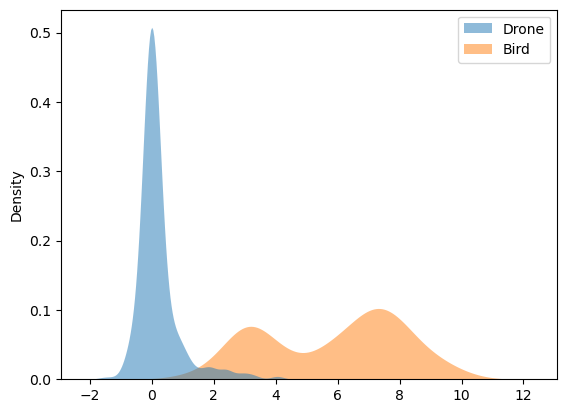

In [112]:
drone_std_speed = np.array(hostile_calc_dict['Stan. Dev. Speed'])
bird_std_speed = np.array(ecco_calc_dict['Stan. Dev. Speed'])
drone_std_head = np.array(hostile_calc_dict['Stan. Dev. Heading'])
bird_std_head = np.array(ecco_calc_dict['Stan. Dev. Heading'])
drone_arti = np.log(drone_std_speed) * drone_std_head
bird_arti = np.log(bird_std_speed) * bird_std_head
# drone_arti = np.sqrt(drone_std_speed) * np.log(drone_std_head)
# bird_arti = np.sqrt(bird_std_speed) * np.log(bird_std_head)
sns.kdeplot({"Drone":drone_arti, "Bird":bird_arti}, fill=True, alpha=.5, linewidth=0)

<Axes: >

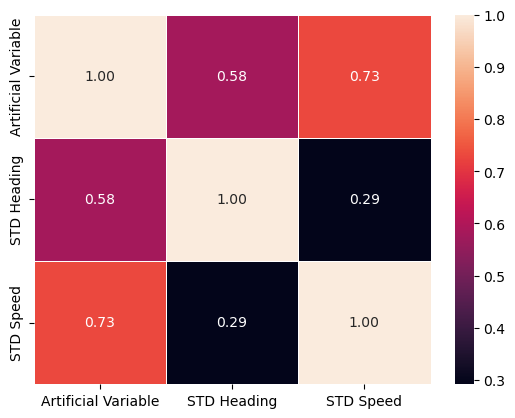

In [62]:
sns.heatmap(np.corrcoef([drone_arti, drone_std_head, drone_std_speed]),annot=True,fmt=".2f", linewidth=.5, xticklabels=["Artificial Variable", "STD Heading", "STD Speed"], yticklabels=["Artificial Variable", "STD Heading", "STD Speed"])


In [ ]:
ecco_m1 = ecco_calc_dict['M1 Speed']
drone_m1 = hostile_calc_dict['M1 Speed']
print(min(ecco_calc_dict['M1 Speed']))
print(max(ecco_calc_dict['M1 Speed']))
print(min(hostile_calc_dict['M1 Speed']))
print(max(hostile_calc_dict['M1 Speed']))
m1_ecco_conf = st.t.interval(alpha=0.90, df=len(ecco_m1)-1, 
                  loc=np.mean(ecco_m1), 
                  scale=st.sem(ecco_m1)) 
sns.kdeplot({"Drone":np.log(np.array(hostile_calc_dict['M1 Speed'])), "Bird":np.log(np.array(ecco_calc_dict['Stan. Dev. Speed']))}, fill=True, alpha=.5, linewidth=0)


In [ ]:

sns.heatmap(np.corrcoef([np.array(hostile_calc_dict['M1 Speed']), drone_std_speed]),annot=True,fmt=".2f", linewidth=.5, xticklabels=['M1 Speed', "STD Speed"], yticklabels=['M1 Speed', "STD Speed"])


### Distribution Visualization

Below are histogram comparisons between the distributions of the drone and bird datasets for all of the original feature vectors specified in section (1). These graphs are used for initial downselection of variables. Ideal candidate vectors for testing the model are variables which show high amounts of disjointness to their opposite class counterpart and which previously showed little correlation to other variables being considered for a given vector.

    Thoughts as of 3/11: Ideal candidates at this stage appear to be $\sigma_{heading}$, M1 or M2 Range, M1 or M2 Heading, M1 or M2 Azimuth, and M1 or M2 EL. The artificial variable could also be useful but currently concerned of the impact it might have on the accuracy of the classifier.

In [81]:
def get_conf_int(conf_lvl, sample_set):
    return st.t.interval(confidence=conf_lvl, df=len(sample_set)-1, 
                  loc=np.mean(sample_set), 
                  scale=st.sem(sample_set)) 

In [176]:
my_hostile_df = pd.DataFrame(hostile_calc_dict)
my_hostile_df['Label'] = 1
my_hostile_df['Target'] = "Drone"
# print(my_hostile_df)

my_ecco_df = pd.DataFrame(ecco_calc_dict)
my_ecco_df['Label'] = 0
my_ecco_df['Target'] = "Bird"
# print(my_ecco_df)

combined_df = pd.concat([my_hostile_df, my_ecco_df], ignore_index=True)

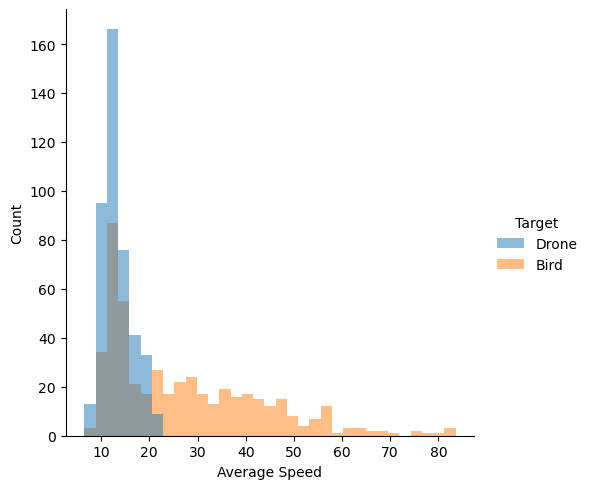

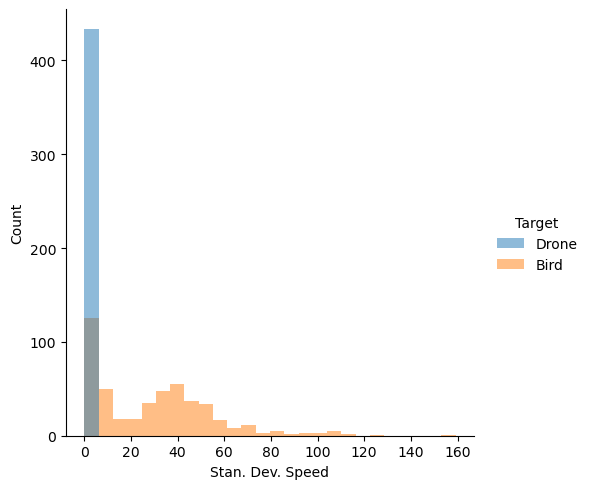

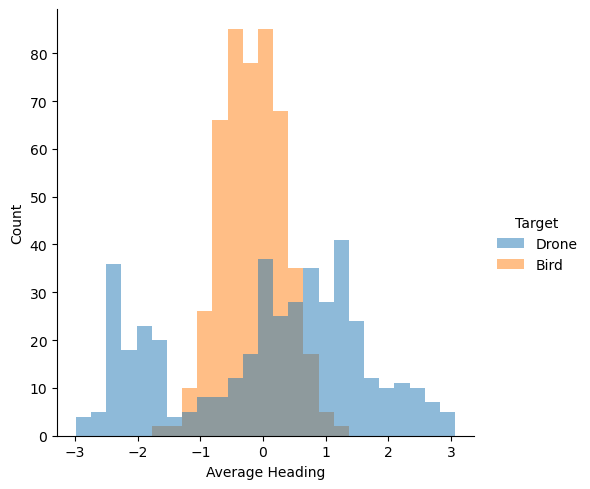

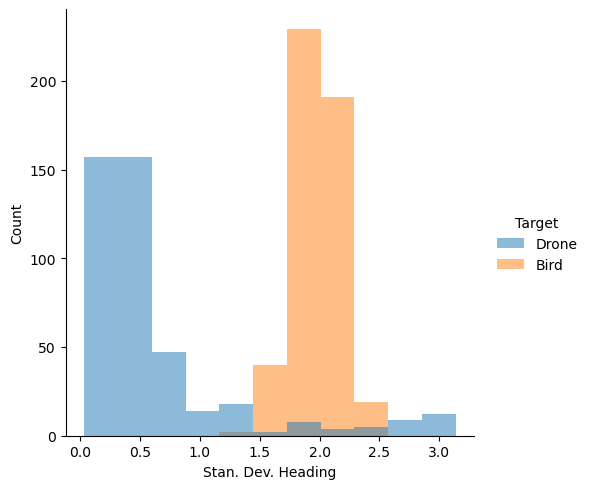

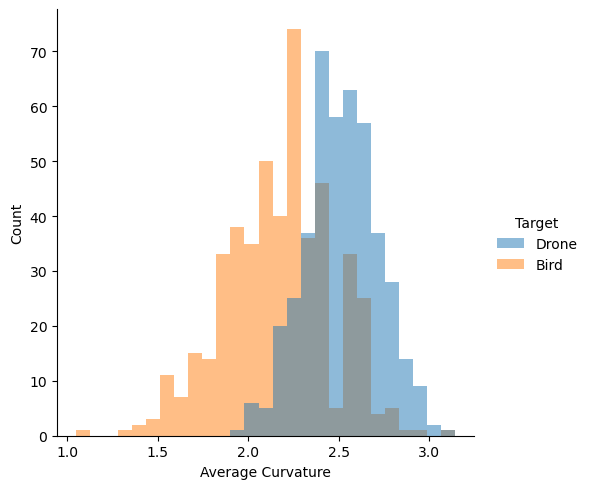

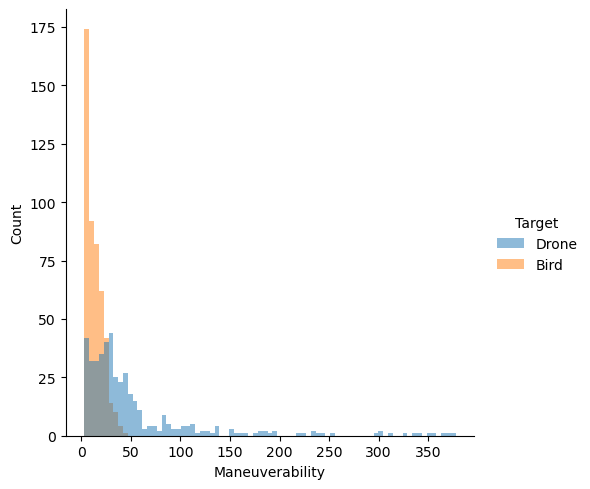

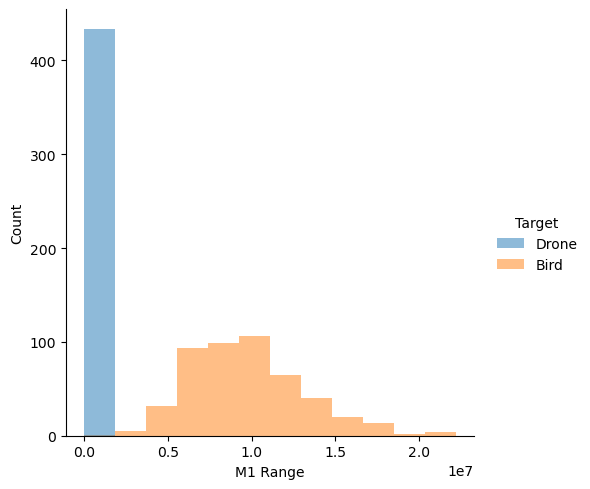

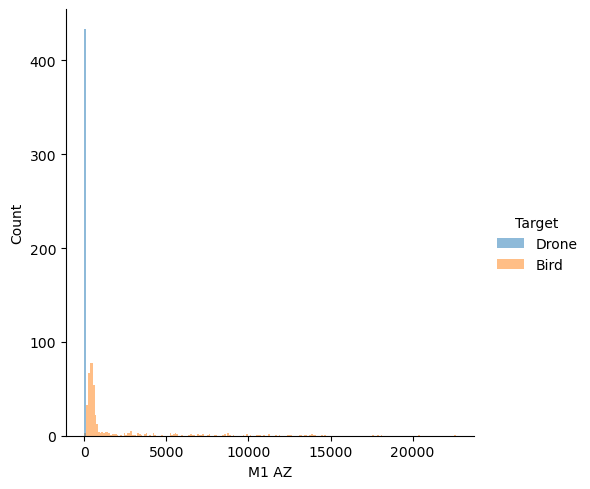

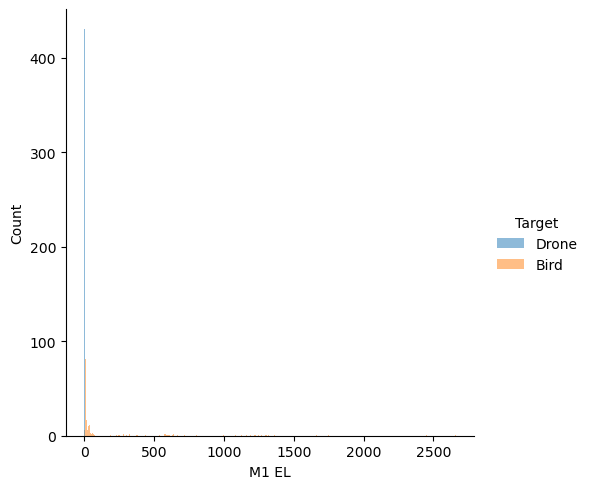

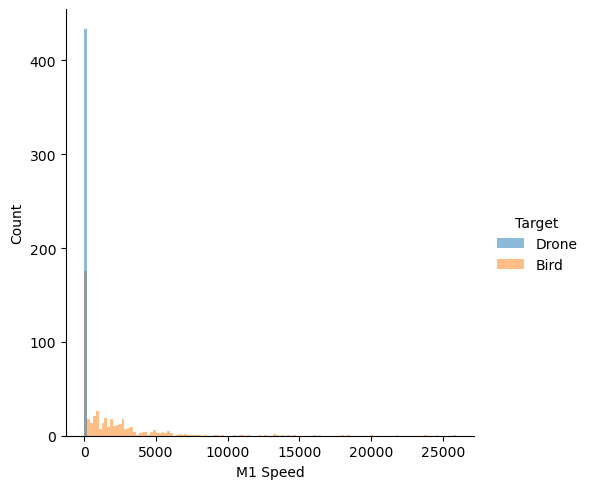

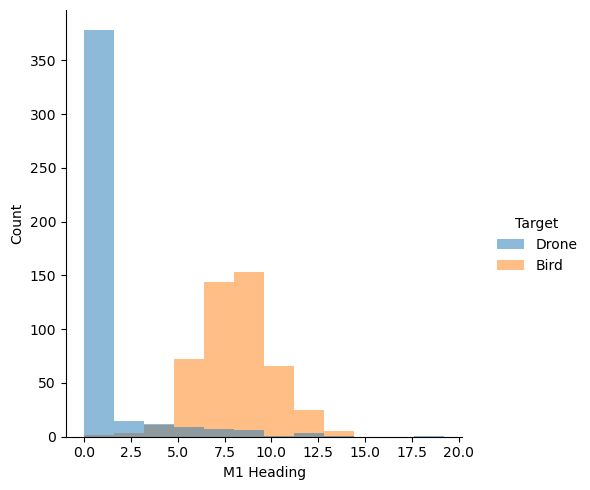

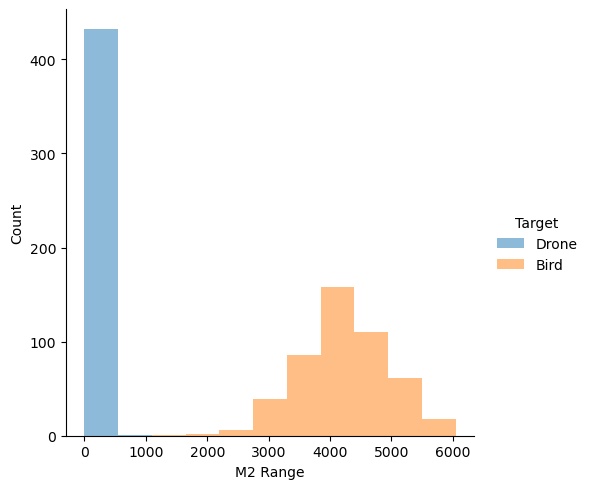

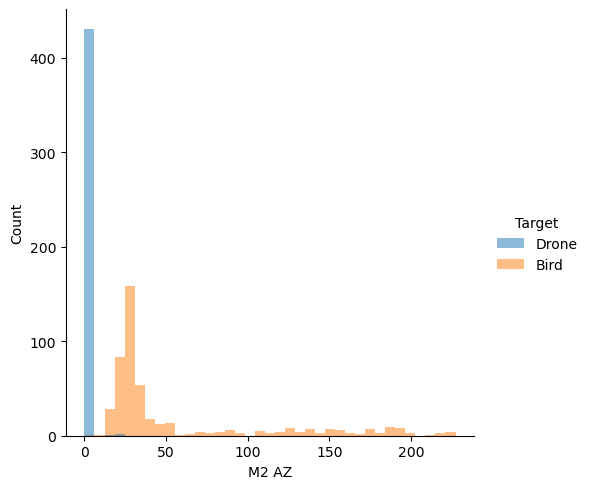

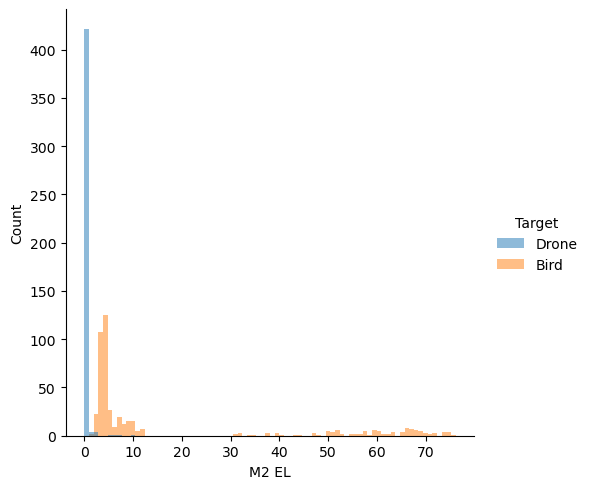

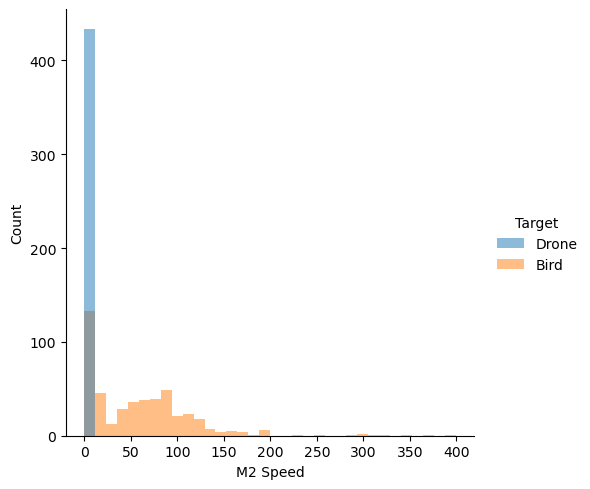

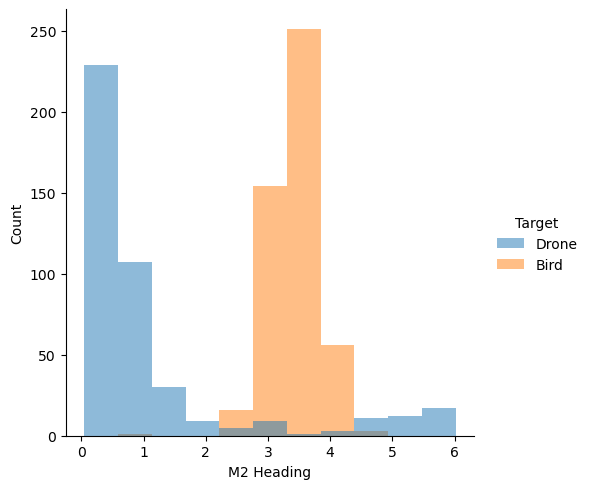

In [178]:
for (drone_key, drone_value), (ecco_key, ecco_value) in zip(hostile_calc_dict.items(), ecco_calc_dict.items()):
    # print("Drone ->   ", drone_key, get_conf_int(.95,drone_value))
    # print("Bird  ->   ", ecco_key, get_conf_int(.95,ecco_value))
    if drone_key != 'UUID':
        plot = sns.displot(combined_df, x=drone_key, hue='Target', fill=True, alpha=.5, linewidth=0)


# Train Classifier

    Thoughts as of 3/11: From initial 2 test feature vectors {$\sigma_{heading}$, M2 Range, M2 AZ, M2 EL} and {M2 Range, M2 AZ, M2 EL}, classifier performance is extremely high. F1 for set 1 (not depicted below) was .99 and the model weighted $\sigma_{heading}$ low on its importance. While it is nice to see high accuracy, my initial reaction is concerns of over fitting, potentially from feature selection or from a poor methodology for track selection. While we know that the testing and training datasets to not overlap in the chunked tracks, these shorter tracks are still being artificially generated from longer tracks which has me suspicious that the testing and training datasets can't be assumed independent. 

In [171]:
import pickle

from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Separate Drone Testing and Training Datasets

In [165]:
hostile_X = pd.DataFrame(
    {
        # 'M2 Heading': hostile_calc_dict['M2 Heading'],
        'M2 Range': hostile_calc_dict['M2 Range'],
        'M2 AZ': hostile_calc_dict['M2 AZ'],
        'M2 EL': hostile_calc_dict['M2 EL'],
    }
)

hostile_Y = pd.DataFrame(my_hostile_df['Label'])
# print(hostile_X)
# print(hostile_Y)

X_hostile_train, X_hostile_test, Y_hostile_train, Y_hostile_test = train_test_split(hostile_X, hostile_Y, test_size=0.3)
# print(X_hostile_test)
# print(Y_hostile_test)

## Separate Bird Testing and Training Datasets

In [166]:
ecco_X = pd.DataFrame(
    {
        # 'M2 Heading': ecco_calc_dict['M2 Heading'],
        'M2 Range': ecco_calc_dict['M2 Range'],
        'M2 AZ': ecco_calc_dict['M2 AZ'],
        'M2 EL': ecco_calc_dict['M2 EL'],
    }
)

ecco_Y = pd.DataFrame(my_ecco_df['Label'])
# print(ecco_X)
# print(ecco_Y)

X_ecco_train, X_ecco_test, Y_ecco_train, Y_ecco_test = train_test_split(ecco_X, ecco_Y, test_size=0.3)
# print(X_ecco_train)
# print(Y_ecco_train)

In [179]:
X_train = pd.concat([X_ecco_train, X_hostile_train], ignore_index=True)
Y_train = np.ravel(pd.concat([Y_ecco_train, Y_hostile_train], ignore_index=True))
X_test = pd.concat([X_ecco_test, X_hostile_test], ignore_index=True)
Y_test = np.ravel(pd.concat([Y_ecco_test, Y_hostile_test], ignore_index=True))
# print(X_test)
# print(Y_test)

In [168]:
# define the classifier
rf = RandomForestClassifier()

# fit model on training data
rf.fit(X_train, Y_train)

# use the trained model to generate predictions
rf_pred = rf.predict(X_test)

# get the confidence levels of each model
rf_confidence_pair = rf.predict_proba(X_test)

In [169]:
accuracy = metrics.accuracy_score(Y_test, rf_pred)
print(f'accuracy = {100 * accuracy}')

accuracy = metrics.f1_score(Y_test, rf_pred)
print(f'f1 score = {100 * accuracy}')

rf_confidence = [max(pair) for pair in rf_confidence_pair]
avg_rf_confidence = np.mean(rf_confidence)
med_rf_confidence = np.median(rf_confidence)

print(f'\naverage confidence level: {avg_rf_confidence}')
print(f'median confidence level: {med_rf_confidence}')

accuracy = 100.0
f1 score = 100.0

average confidence level: 0.9957454545454547
median confidence level: 1.0


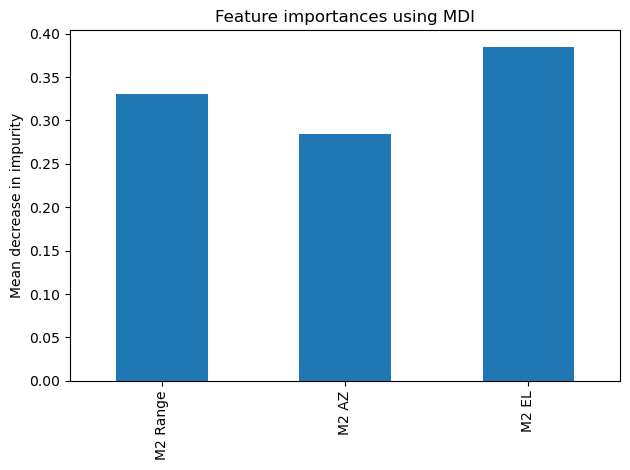

In [170]:
importance = rf.feature_importances_

forest_importance = pd.Series(importance, index=list(X_train.columns))

fig, ax = plt.subplots()
forest_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [172]:
filename = '../models/mar11_fv.sav'
pickle.dump(rf, open(filename, 'wb'))